In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)
from libs.lib import *


d:\ads_test


In [2]:
exps_dir = "../../../exps/exp1"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/data"
os.makedirs(save_dir, exist_ok=True)


In [3]:
wandb.init(
    # set the wandb project where this run will be logged
    project="ads2_prj_VGG16"
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dinhtanloc (nckh_ueh). Use `wandb login --relogin` to force relogin


In [4]:
# Dữ liệu
x_train = pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train = pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test = pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test = pd.read_excel(f'{save_dir}/y_test.xlsx')

In [5]:
from sklearn.metrics import f1_score
import tensorflow as tf
def f1_loss(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))
    predicted_positives = tf.reduce_sum(tf.cast(y_pred, tf.float32))
    possible_positives = tf.reduce_sum(tf.cast(y_true, tf.float32))
    
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return 1 - f1

In [6]:
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    loss = -tf.reduce_mean(alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt))
    return loss


In [7]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    return 1 - (numerator + 1) / (denominator + 1)


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred, smooth=0.0001):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [9]:
from keras import backend as K

def f1_score(y_true, y_pred):
    """
    F1 score metric.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

In [10]:
from tensorflow.keras.optimizers.legacy import Adam
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Flatten
from keras.models import Model
from keras.layers import Input
import tensorflow as tf
input_shape =(x_train.shape[1],1)
x_input = Input(shape=input_shape)
dense_units = 1024
learning_rate = 0.0001
kernel_size =3
filter_size=96


# Block 1
x = Conv1D(filter_size, kernel_size, activation='relu', padding='same', name='block1_conv1')(x_input)
x = Conv1D(filter_size, kernel_size, activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling1D(2, strides=2, name='block1_pool')(x)

# Block 2
x = Conv1D(filter_size*2, kernel_size, activation='relu', padding='same', name='block2_conv1')(x)
x = Conv1D(filter_size*2, kernel_size, activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling1D(2, strides=2, name='block2_pool')(x)

# Block 3
x = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv1')(x)
x = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv2')(x)
x = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block3_pool')(x)

# Block 4
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv1')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv2')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block4_pool')(x)

# Block 5
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv1')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv2')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block5_pool')(x)

# x = Flatten(name='flatten')(x)
# x = Dense(dense_units, activation='relu', name='fc1')(x)
# x = Dense(dense_units, activation='relu', name='fc2')(x)
# x = Dense(1, activation='sigmoid', name='predictions')(x)  # Sigmoid for binary classification

x = GlobalAveragePooling1D()(x)
# x = GlobalMaxPooling1D()(x)
# x = Dense(2, activation='softmax', name='predictions')(x)  # Sigmoid for binary classification
x = Dense(1, activation='sigmoid', name='predictions')(x)  # Sigmoid for binary classification

# Create model.
model = Model(x_input, x, name='vgg16')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy',f1_score])

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=f1_loss, metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=focal_loss, metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=dice_coef_loss, metrics=['accuracy',f1_score])
early_stopping = EarlyStopping(monitor='val_accuracy',
    # min_delta=0.00005,
    patience=60,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.95,
    patience=10,
    min_lr=0.000001,
    verbose=1,
)


In [11]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 34, 1)]           0         
                                                                 
 block1_conv1 (Conv1D)       (None, 34, 96)            384       
                                                                 
 block1_conv2 (Conv1D)       (None, 34, 96)            27744     
                                                                 
 block1_pool (MaxPooling1D)  (None, 17, 96)            0         
                                                                 
 block2_conv1 (Conv1D)       (None, 17, 192)           55488     
                                                                 
 block2_conv2 (Conv1D)       (None, 17, 192)           110784    
                                                                 
 block2_pool (MaxPooling1D)  (None, 8, 192)            0     

In [12]:
def show_pic(times):
    history=model.history.history
    fig,axes=plt.subplots(1,2, figsize=(15,8))
    axes[0].plot(pd.DataFrame(history['val_accuracy']))
    axes[0].set_title('Training Process')

    axes[1].plot(pd.DataFrame(history['accuracy']), label='Train Accuracy')
    axes[1].plot(pd.DataFrame(history['val_accuracy']), label='Validation Accuracy')
    axes[1].plot(pd.DataFrame(history['loss']), label='Train Loss')
    axes[1].plot(pd.DataFrame(history['val_loss']), label='Validation Loss')
    axes[1].set_title(f'Training Process in {times}')
    axes[1].legend()
    plt.show()


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
274/274 [==============================] - ETA: 0s - loss: 0.6234 - accuracy: 0.6161 - f1_score: 0.5380INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best)... Done. 0.3s


274/274 [==============================] - 100s 358ms/step - loss: 0.6234 - accuracy: 0.6161 - f1_score: 0.5380 - val_loss: 0.3982 - val_accuracy: 0.8230 - val_f1_score: 0.5538
Epoch 2/10
274/274 [==============================] - ETA: 0s - loss: 0.3750 - accuracy: 0.8355 - f1_score: 0.8410INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best)... Done. 0.2s


274/274 [==============================] - 96s 351ms/step - loss: 0.3750 - accuracy: 0.8355 - f1_score: 0.8410 - val_loss: 0.3262 - val_accuracy: 0.8729 - val_f1_score: 0.5651
Epoch 3/10
274/274 [==============================] - ETA: 0s - loss: 0.3023 - accuracy: 0.8721 - f1_score: 0.8731INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best)... Done. 0.3s


274/274 [==============================] - 99s 360ms/step - loss: 0.3023 - accuracy: 0.8721 - f1_score: 0.8731 - val_loss: 0.2623 - val_accuracy: 0.8981 - val_f1_score: 0.5797
Epoch 4/10
274/274 [==============================] - ETA: 0s - loss: 0.2688 - accuracy: 0.8896 - f1_score: 0.8886INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best)... Done. 0.3s


274/274 [==============================] - 98s 358ms/step - loss: 0.2688 - accuracy: 0.8896 - f1_score: 0.8886 - val_loss: 0.2621 - val_accuracy: 0.8893 - val_f1_score: 0.6128
Epoch 5/10
274/274 [==============================] - ETA: 0s - loss: 0.2385 - accuracy: 0.9053 - f1_score: 0.9047INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best)... Done. 0.2s


274/274 [==============================] - 98s 359ms/step - loss: 0.2385 - accuracy: 0.9053 - f1_score: 0.9047 - val_loss: 0.2213 - val_accuracy: 0.9084 - val_f1_score: 0.5995
Epoch 6/10
274/274 [==============================] - ETA: 0s - loss: 0.2161 - accuracy: 0.9143 - f1_score: 0.9135INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best)... Done. 0.3s


274/274 [==============================] - 97s 355ms/step - loss: 0.2161 - accuracy: 0.9143 - f1_score: 0.9135 - val_loss: 0.2203 - val_accuracy: 0.9099 - val_f1_score: 0.5653
Epoch 7/10
274/274 [==============================] - ETA: 0s - loss: 0.1928 - accuracy: 0.9225 - f1_score: 0.9223INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best)... Done. 0.3s


274/274 [==============================] - 98s 356ms/step - loss: 0.1928 - accuracy: 0.9225 - f1_score: 0.9223 - val_loss: 0.1964 - val_accuracy: 0.9202 - val_f1_score: 0.6253
Epoch 8/10
274/274 [==============================] - 94s 343ms/step - loss: 0.1757 - accuracy: 0.9320 - f1_score: 0.9313 - val_loss: 0.2023 - val_accuracy: 0.9177 - val_f1_score: 0.6166
Epoch 9/10
274/274 [==============================] - ETA: 0s - loss: 0.1565 - accuracy: 0.9417 - f1_score: 0.9416INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best)... Done. 0.3s


274/274 [==============================] - 97s 355ms/step - loss: 0.1565 - accuracy: 0.9417 - f1_score: 0.9416 - val_loss: 0.1888 - val_accuracy: 0.9290 - val_f1_score: 0.6251
Epoch 10/10
274/274 [==============================] - 95s 348ms/step - loss: 0.1419 - accuracy: 0.9469 - f1_score: 0.9460 - val_loss: 0.2082 - val_accuracy: 0.9171 - val_f1_score: 0.6404


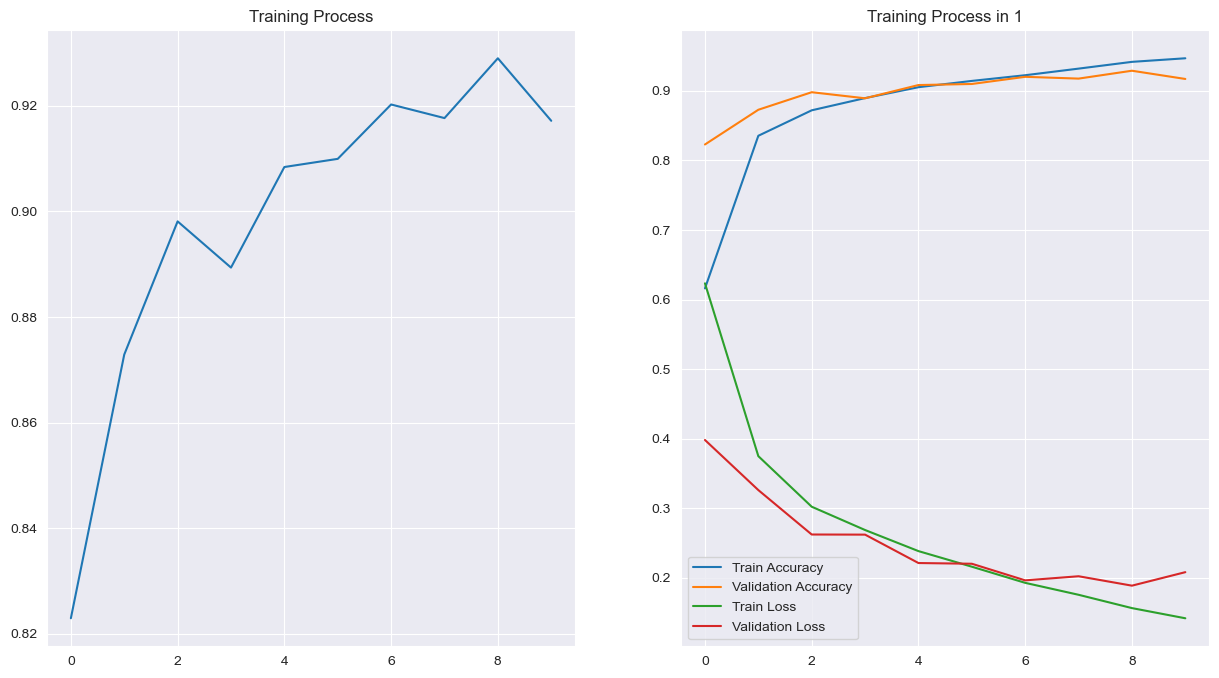

Epoch 1/10
274/274 [==============================] - ETA: 0s - loss: 0.1435 - accuracy: 0.9455 - f1_score: 0.9449INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best)... Done. 0.4s


274/274 [==============================] - 99s 361ms/step - loss: 0.1435 - accuracy: 0.9455 - f1_score: 0.9449 - val_loss: 0.1113 - val_accuracy: 0.9640 - val_f1_score: 0.7780
Epoch 2/10
274/274 [==============================] - ETA: 0s - loss: 0.1179 - accuracy: 0.9561 - f1_score: 0.9554INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best)... Done. 0.2s


274/274 [==============================] - 99s 362ms/step - loss: 0.1179 - accuracy: 0.9561 - f1_score: 0.9554 - val_loss: 0.1093 - val_accuracy: 0.9609 - val_f1_score: 0.7403
Epoch 3/10
274/274 [==============================] - 94s 344ms/step - loss: 0.1103 - accuracy: 0.9591 - f1_score: 0.9581 - val_loss: 0.1303 - val_accuracy: 0.9516 - val_f1_score: 0.7358
Epoch 4/10
274/274 [==============================] - ETA: 0s - loss: 0.0971 - accuracy: 0.9640 - f1_score: 0.9635INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best)... Done. 0.3s


274/274 [==============================] - 97s 352ms/step - loss: 0.0971 - accuracy: 0.9640 - f1_score: 0.9635 - val_loss: 0.0936 - val_accuracy: 0.9660 - val_f1_score: 0.7579
Epoch 5/10
274/274 [==============================] - 96s 349ms/step - loss: 0.0852 - accuracy: 0.9684 - f1_score: 0.9677 - val_loss: 0.1154 - val_accuracy: 0.9619 - val_f1_score: 0.7524
Epoch 6/10
274/274 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.9700 - f1_score: 0.9694INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best)... Done. 0.3s


274/274 [==============================] - 97s 354ms/step - loss: 0.0808 - accuracy: 0.9700 - f1_score: 0.9694 - val_loss: 0.0816 - val_accuracy: 0.9696 - val_f1_score: 0.7699
Epoch 7/10
274/274 [==============================] - 95s 347ms/step - loss: 0.0707 - accuracy: 0.9742 - f1_score: 0.9735 - val_loss: 0.1255 - val_accuracy: 0.9568 - val_f1_score: 0.7543
Epoch 8/10
274/274 [==============================] - 98s 358ms/step - loss: 0.0653 - accuracy: 0.9762 - f1_score: 0.9760 - val_loss: 0.1230 - val_accuracy: 0.9635 - val_f1_score: 0.7231
Epoch 9/10
274/274 [==============================] - 105s 383ms/step - loss: 0.0601 - accuracy: 0.9780 - f1_score: 0.9777 - val_loss: 0.1071 - val_accuracy: 0.9624 - val_f1_score: 0.7689
Epoch 10/10
274/274 [==============================] - 94s 342ms/step - loss: 0.0568 - accuracy: 0.9794 - f1_score: 0.9788 - val_loss: 0.0867 - val_accuracy: 0.9650 - val_f1_score: 0.7362


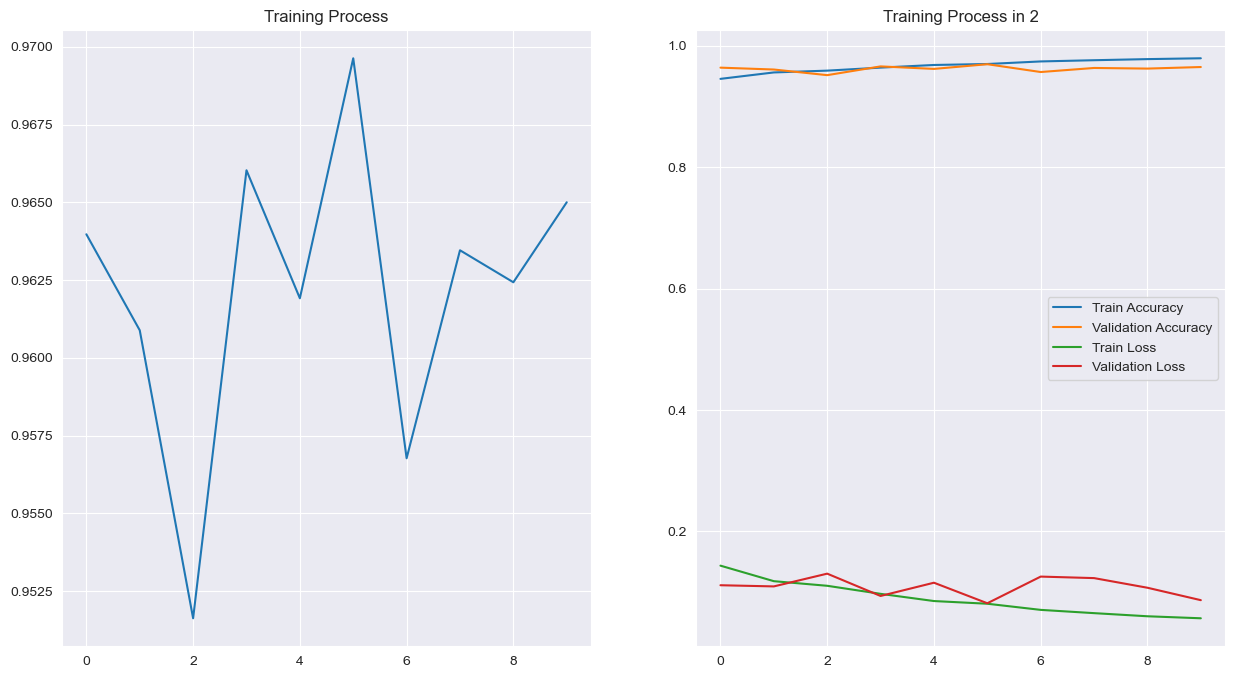

Epoch 1/10
274/274 [==============================] - ETA: 0s - loss: 0.0557 - accuracy: 0.9802 - f1_score: 0.9796INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best)... Done. 0.3s


274/274 [==============================] - 108s 394ms/step - loss: 0.0557 - accuracy: 0.9802 - f1_score: 0.9796 - val_loss: 0.0578 - val_accuracy: 0.9753 - val_f1_score: 0.8444
Epoch 2/10
274/274 [==============================] - ETA: 0s - loss: 0.0520 - accuracy: 0.9800 - f1_score: 0.9798INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best)... Done. 0.2s


274/274 [==============================] - 97s 354ms/step - loss: 0.0520 - accuracy: 0.9800 - f1_score: 0.9798 - val_loss: 0.0438 - val_accuracy: 0.9804 - val_f1_score: 0.9323
Epoch 3/10
274/274 [==============================] - 92s 334ms/step - loss: 0.0440 - accuracy: 0.9840 - f1_score: 0.9839 - val_loss: 0.0441 - val_accuracy: 0.9830 - val_f1_score: 0.9312
Epoch 4/10
274/274 [==============================] - ETA: 0s - loss: 0.0410 - accuracy: 0.9847 - f1_score: 0.9843INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best)... Done. 0.3s


274/274 [==============================] - 93s 341ms/step - loss: 0.0410 - accuracy: 0.9847 - f1_score: 0.9843 - val_loss: 0.0383 - val_accuracy: 0.9846 - val_f1_score: 0.8879
Epoch 5/10
274/274 [==============================] - 90s 329ms/step - loss: 0.0433 - accuracy: 0.9847 - f1_score: 0.9843 - val_loss: 0.0750 - val_accuracy: 0.9727 - val_f1_score: 0.8096
Epoch 6/10
274/274 [==============================] - ETA: 0s - loss: 0.0361 - accuracy: 0.9867 - f1_score: 0.9866INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best)... Done. 0.3s


274/274 [==============================] - 92s 337ms/step - loss: 0.0361 - accuracy: 0.9867 - f1_score: 0.9866 - val_loss: 0.0360 - val_accuracy: 0.9892 - val_f1_score: 0.9208
Epoch 7/10
274/274 [==============================] - 91s 331ms/step - loss: 0.0289 - accuracy: 0.9892 - f1_score: 0.9891 - val_loss: 0.0587 - val_accuracy: 0.9804 - val_f1_score: 0.8409
Epoch 8/10
274/274 [==============================] - 91s 333ms/step - loss: 0.0289 - accuracy: 0.9899 - f1_score: 0.9896 - val_loss: 0.0478 - val_accuracy: 0.9840 - val_f1_score: 0.8949
Epoch 9/10
274/274 [==============================] - 91s 333ms/step - loss: 0.0301 - accuracy: 0.9890 - f1_score: 0.9887 - val_loss: 0.0629 - val_accuracy: 0.9758 - val_f1_score: 0.8258
Epoch 10/10
274/274 [==============================] - 91s 331ms/step - loss: 0.0287 - accuracy: 0.9901 - f1_score: 0.9900 - val_loss: 0.0406 - val_accuracy: 0.9846 - val_f1_score: 0.8856


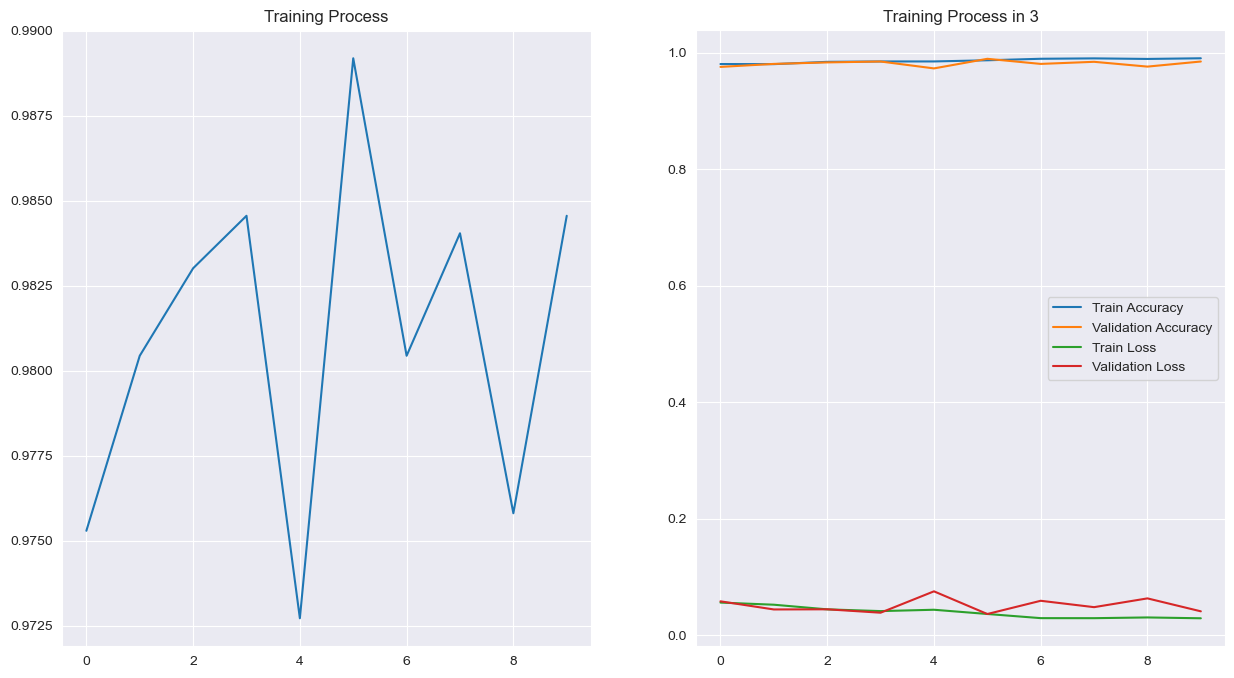

Epoch 1/10
274/274 [==============================] - 94s 343ms/step - loss: 0.0304 - accuracy: 0.9902 - f1_score: 0.9903 - val_loss: 0.0388 - val_accuracy: 0.9856 - val_f1_score: 0.8622
Epoch 2/10
274/274 [==============================] - ETA: 0s - loss: 0.0285 - accuracy: 0.9895 - f1_score: 0.9892INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best)... Done. 0.3s


274/274 [==============================] - 94s 343ms/step - loss: 0.0285 - accuracy: 0.9895 - f1_score: 0.9892 - val_loss: 0.0314 - val_accuracy: 0.9892 - val_f1_score: 0.8905
Epoch 3/10
274/274 [==============================] - 99s 360ms/step - loss: 0.0274 - accuracy: 0.9907 - f1_score: 0.9906 - val_loss: 0.0428 - val_accuracy: 0.9846 - val_f1_score: 0.8804
Epoch 4/10
274/274 [==============================] - ETA: 0s - loss: 0.0222 - accuracy: 0.9923 - f1_score: 0.9921INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best)... Done. 0.3s


274/274 [==============================] - 101s 368ms/step - loss: 0.0222 - accuracy: 0.9923 - f1_score: 0.9921 - val_loss: 0.0269 - val_accuracy: 0.9892 - val_f1_score: 0.9097
Epoch 5/10
274/274 [==============================] - 100s 365ms/step - loss: 0.0220 - accuracy: 0.9922 - f1_score: 0.9921 - val_loss: 0.0433 - val_accuracy: 0.9835 - val_f1_score: 0.8643
Epoch 6/10
274/274 [==============================] - 98s 359ms/step - loss: 0.0222 - accuracy: 0.9930 - f1_score: 0.9929 - val_loss: 0.0751 - val_accuracy: 0.9789 - val_f1_score: 0.8563
Epoch 7/10
274/274 [==============================] - 98s 359ms/step - loss: 0.0240 - accuracy: 0.9920 - f1_score: 0.9919 - val_loss: 0.0303 - val_accuracy: 0.9897 - val_f1_score: 0.8895
Epoch 8/10
274/274 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9932 - f1_score: 0.9930INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best)... Done. 0.4s


274/274 [==============================] - 116s 422ms/step - loss: 0.0185 - accuracy: 0.9932 - f1_score: 0.9930 - val_loss: 0.0255 - val_accuracy: 0.9913 - val_f1_score: 0.9026
Epoch 9/10
274/274 [==============================] - 97s 354ms/step - loss: 0.0180 - accuracy: 0.9933 - f1_score: 0.9931 - val_loss: 0.0421 - val_accuracy: 0.9851 - val_f1_score: 0.8862
Epoch 10/10
274/274 [==============================] - 98s 359ms/step - loss: 0.0217 - accuracy: 0.9925 - f1_score: 0.9925 - val_loss: 0.0262 - val_accuracy: 0.9928 - val_f1_score: 0.9167


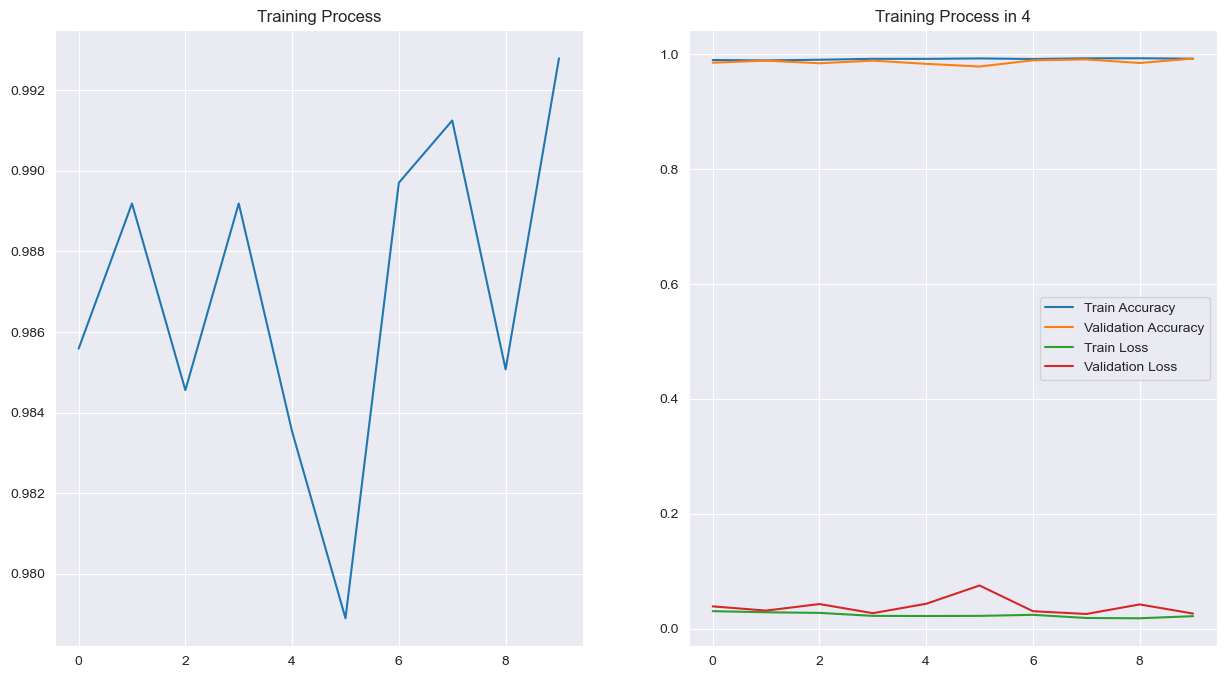

Epoch 1/10
274/274 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.9929 - f1_score: 0.9927INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best)... Done. 0.4s


274/274 [==============================] - 102s 372ms/step - loss: 0.0205 - accuracy: 0.9929 - f1_score: 0.9927 - val_loss: 0.0104 - val_accuracy: 0.9969 - val_f1_score: 0.9802
Epoch 2/10
274/274 [==============================] - 96s 350ms/step - loss: 0.0188 - accuracy: 0.9941 - f1_score: 0.9940 - val_loss: 0.0111 - val_accuracy: 0.9943 - val_f1_score: 0.9673
Epoch 3/10
274/274 [==============================] - 102s 371ms/step - loss: 0.0199 - accuracy: 0.9932 - f1_score: 0.9930 - val_loss: 0.0175 - val_accuracy: 0.9949 - val_f1_score: 0.9661
Epoch 4/10
274/274 [==============================] - 100s 363ms/step - loss: 0.0166 - accuracy: 0.9942 - f1_score: 0.9941 - val_loss: 0.0254 - val_accuracy: 0.9913 - val_f1_score: 0.9478
Epoch 5/10
274/274 [==============================] - 103s 376ms/step - loss: 0.0178 - accuracy: 0.9937 - f1_score: 0.9935 - val_loss: 0.0114 - val_accuracy: 0.9964 - val_f1_score: 0.9667
Epoch 6/10
274/274 [==============================] - 101s 370ms/step - 

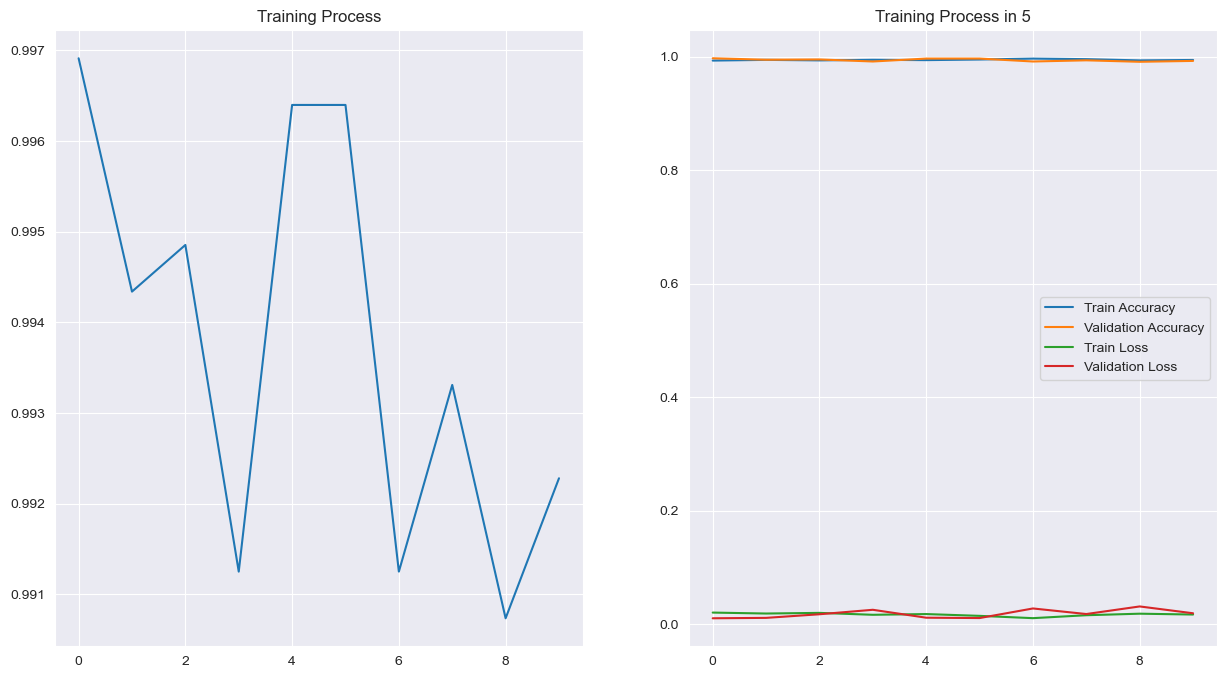

Epoch 1/10
274/274 [==============================] - 116s 425ms/step - loss: 0.0169 - accuracy: 0.9945 - f1_score: 0.9945 - val_loss: 0.0121 - val_accuracy: 0.9954 - val_f1_score: 0.9572
Epoch 2/10
274/274 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9936 - f1_score: 0.9935INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best)... Done. 0.3s


274/274 [==============================] - 99s 360ms/step - loss: 0.0174 - accuracy: 0.9936 - f1_score: 0.9935 - val_loss: 0.0103 - val_accuracy: 0.9964 - val_f1_score: 0.9827
Epoch 3/10
274/274 [==============================] - 96s 350ms/step - loss: 0.0088 - accuracy: 0.9970 - f1_score: 0.9970 - val_loss: 0.0457 - val_accuracy: 0.9887 - val_f1_score: 0.9417
Epoch 4/10
274/274 [==============================] - 101s 368ms/step - loss: 0.0169 - accuracy: 0.9943 - f1_score: 0.9943 - val_loss: 0.0218 - val_accuracy: 0.9928 - val_f1_score: 0.9180
Epoch 5/10
274/274 [==============================] - 102s 371ms/step - loss: 0.0119 - accuracy: 0.9961 - f1_score: 0.9960 - val_loss: 0.0128 - val_accuracy: 0.9949 - val_f1_score: 0.9718
Epoch 6/10
274/274 [==============================] - 114s 415ms/step - loss: 0.0177 - accuracy: 0.9943 - f1_score: 0.9942 - val_loss: 0.0353 - val_accuracy: 0.9861 - val_f1_score: 0.8761
Epoch 7/10
274/274 [==============================] - 106s 389ms/step - l

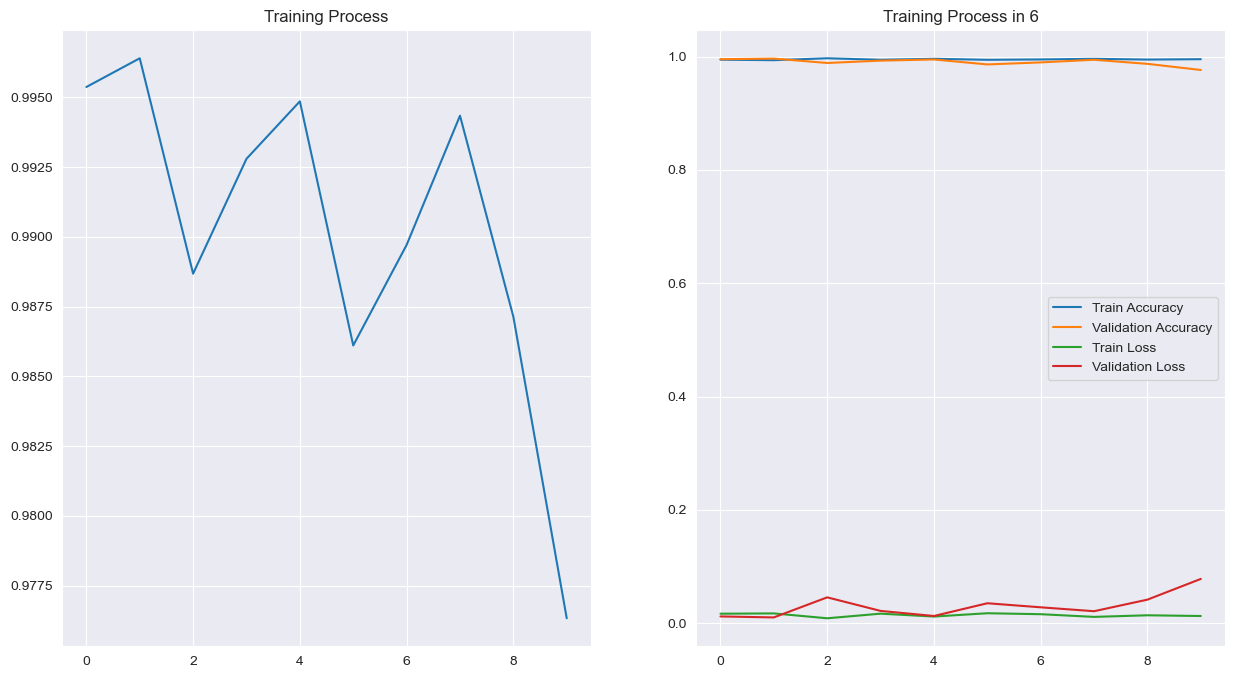

Epoch 1/10
274/274 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 0.9955 - f1_score: 0.9954INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best)... Done. 0.2s


274/274 [==============================] - 100s 365ms/step - loss: 0.0139 - accuracy: 0.9955 - f1_score: 0.9954 - val_loss: 0.0068 - val_accuracy: 0.9969 - val_f1_score: 0.9804
Epoch 2/10
274/274 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9963 - f1_score: 0.9963INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best)... Done. 0.2s


274/274 [==============================] - 91s 333ms/step - loss: 0.0103 - accuracy: 0.9963 - f1_score: 0.9963 - val_loss: 0.0067 - val_accuracy: 0.9974 - val_f1_score: 0.9761
Epoch 3/10
274/274 [==============================] - 89s 324ms/step - loss: 0.0061 - accuracy: 0.9981 - f1_score: 0.9981 - val_loss: 0.0273 - val_accuracy: 0.9907 - val_f1_score: 0.9678
Epoch 4/10
274/274 [==============================] - 97s 355ms/step - loss: 0.0124 - accuracy: 0.9957 - f1_score: 0.9955 - val_loss: 0.0396 - val_accuracy: 0.9887 - val_f1_score: 0.9025
Epoch 5/10
274/274 [==============================] - 101s 370ms/step - loss: 0.0135 - accuracy: 0.9950 - f1_score: 0.9949 - val_loss: 0.0209 - val_accuracy: 0.9923 - val_f1_score: 0.9472
Epoch 6/10
274/274 [==============================] - 92s 337ms/step - loss: 0.0102 - accuracy: 0.9963 - f1_score: 0.9963 - val_loss: 0.0371 - val_accuracy: 0.9887 - val_f1_score: 0.9140
Epoch 7/10
274/274 [==============================] - 93s 338ms/step - loss

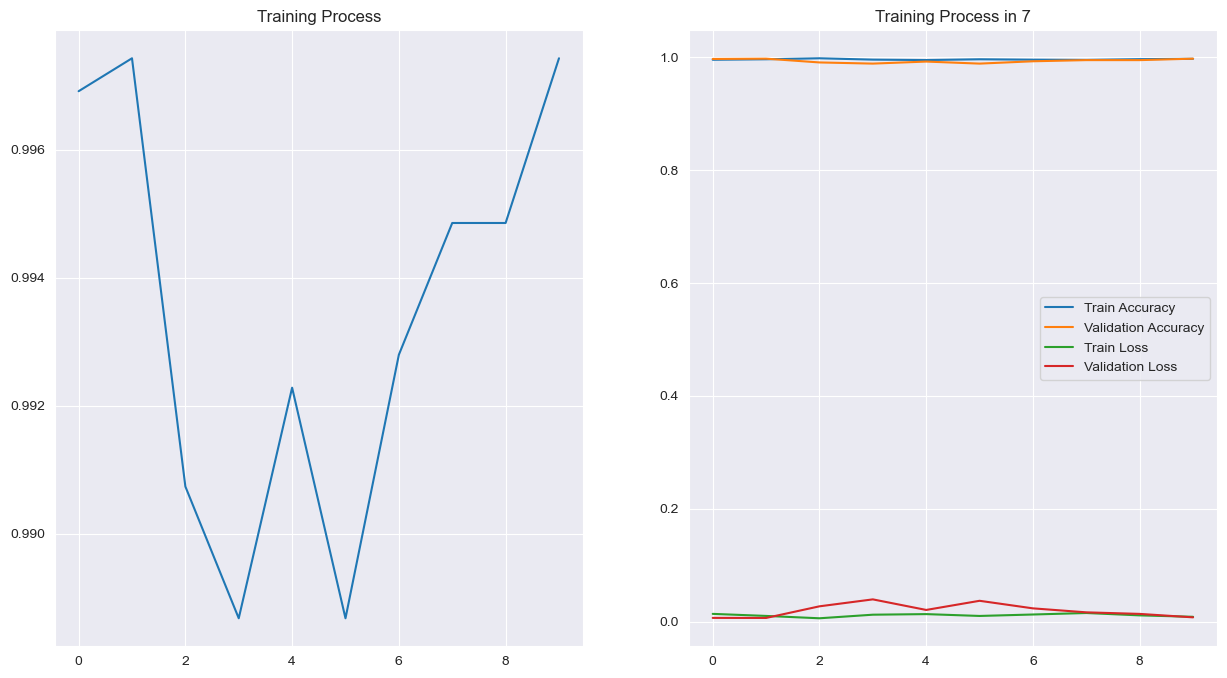

Epoch 1/10
274/274 [==============================] - 118s 430ms/step - loss: 0.0108 - accuracy: 0.9970 - f1_score: 0.9969 - val_loss: 0.0079 - val_accuracy: 0.9974 - val_f1_score: 0.9825
Epoch 2/10
274/274 [==============================] - 111s 406ms/step - loss: 0.0102 - accuracy: 0.9971 - f1_score: 0.9972 - val_loss: 0.0082 - val_accuracy: 0.9974 - val_f1_score: 0.9890
Epoch 3/10
274/274 [==============================] - 111s 403ms/step - loss: 0.0129 - accuracy: 0.9955 - f1_score: 0.9955 - val_loss: 0.0134 - val_accuracy: 0.9938 - val_f1_score: 0.9606
Epoch 4/10
274/274 [==============================] - 103s 378ms/step - loss: 0.0103 - accuracy: 0.9963 - f1_score: 0.9963 - val_loss: 0.0085 - val_accuracy: 0.9969 - val_f1_score: 0.9717
Epoch 5/10
274/274 [==============================] - 108s 395ms/step - loss: 0.0100 - accuracy: 0.9968 - f1_score: 0.9966 - val_loss: 0.0072 - val_accuracy: 0.9974 - val_f1_score: 0.9727
Epoch 6/10
274/274 [==============================] - 100s 3

INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best)... Done. 0.2s


274/274 [==============================] - 114s 418ms/step - loss: 0.0061 - accuracy: 0.9983 - f1_score: 0.9983 - val_loss: 0.0035 - val_accuracy: 0.9985 - val_f1_score: 0.9838
Epoch 9/10
274/274 [==============================] - 95s 348ms/step - loss: 0.0083 - accuracy: 0.9976 - f1_score: 0.9976 - val_loss: 0.0173 - val_accuracy: 0.9949 - val_f1_score: 0.9687
Epoch 10/10
274/274 [==============================] - ETA: 0s - loss: 0.0099 - accuracy: 0.9969 - f1_score: 0.9968INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240423_143607-itxnvx1p\files\model-best)... Done. 0.3s


274/274 [==============================] - 97s 354ms/step - loss: 0.0099 - accuracy: 0.9969 - f1_score: 0.9968 - val_loss: 0.0035 - val_accuracy: 0.9979 - val_f1_score: 0.9796


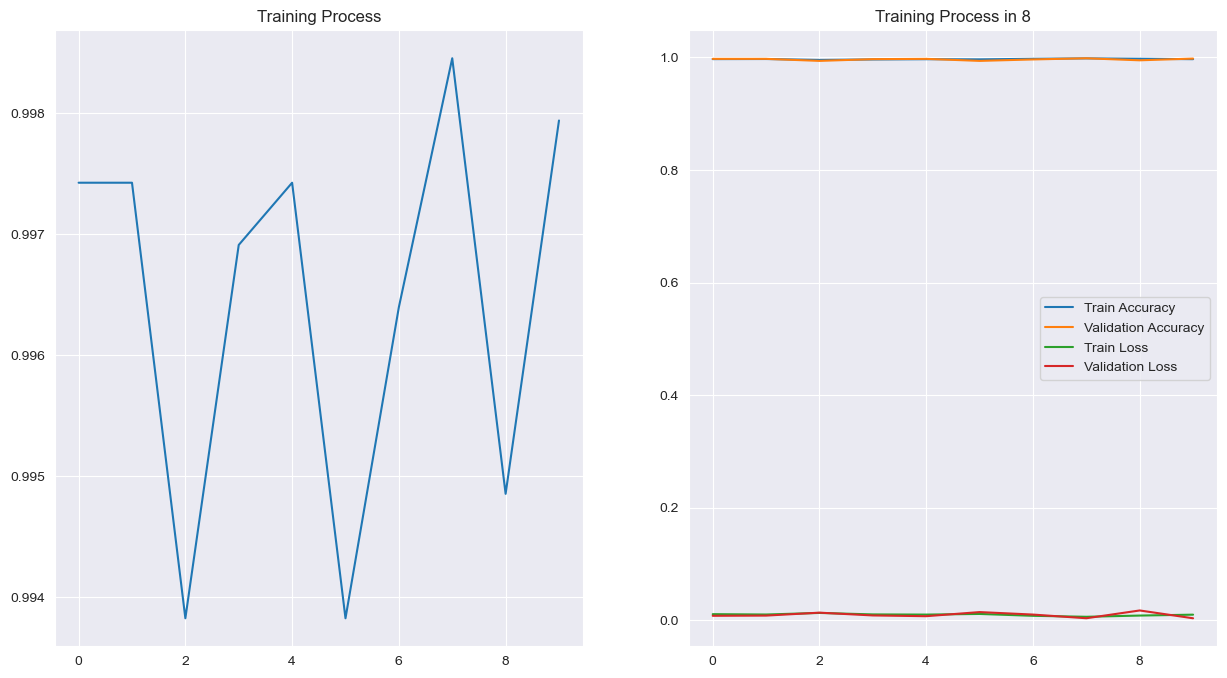

Epoch 1/10
274/274 [==============================] - 99s 362ms/step - loss: 0.0110 - accuracy: 0.9966 - f1_score: 0.9965 - val_loss: 0.0080 - val_accuracy: 0.9974 - val_f1_score: 0.9861
Epoch 2/10
274/274 [==============================] - 99s 362ms/step - loss: 0.0104 - accuracy: 0.9970 - f1_score: 0.9970 - val_loss: 0.0087 - val_accuracy: 0.9959 - val_f1_score: 0.9779
Epoch 3/10
274/274 [==============================] - 99s 361ms/step - loss: 0.0090 - accuracy: 0.9971 - f1_score: 0.9971 - val_loss: 0.0052 - val_accuracy: 0.9990 - val_f1_score: 0.9929
Epoch 4/10
274/274 [==============================] - 99s 362ms/step - loss: 0.0087 - accuracy: 0.9973 - f1_score: 0.9972 - val_loss: 0.0139 - val_accuracy: 0.9954 - val_f1_score: 0.9735
Epoch 5/10
274/274 [==============================] - 98s 358ms/step - loss: 0.0118 - accuracy: 0.9954 - f1_score: 0.9954 - val_loss: 0.0183 - val_accuracy: 0.9918 - val_f1_score: 0.9721
Epoch 6/10
274/274 [==============================] - 121s 440ms/

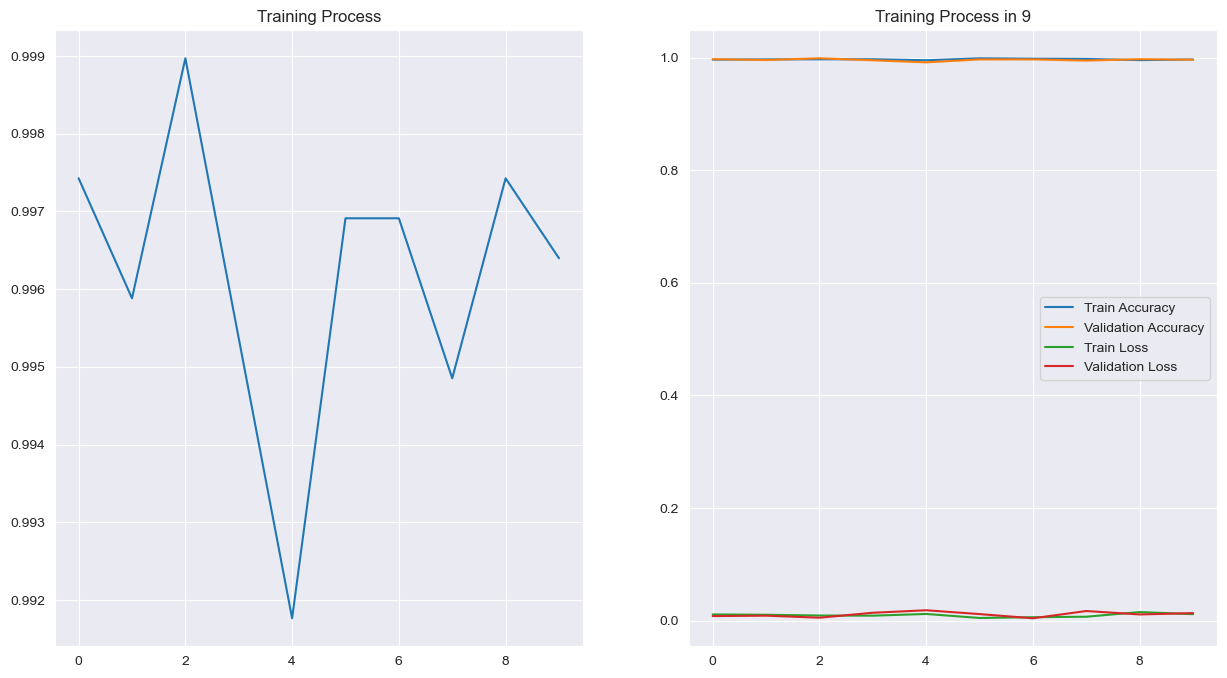

Epoch 1/10
274/274 [==============================] - 104s 380ms/step - loss: 0.0087 - accuracy: 0.9973 - f1_score: 0.9972 - val_loss: 0.0141 - val_accuracy: 0.9959 - val_f1_score: 0.9884
Epoch 2/10
274/274 [==============================] - 100s 364ms/step - loss: 0.0066 - accuracy: 0.9977 - f1_score: 0.9978 - val_loss: 0.0050 - val_accuracy: 0.9990 - val_f1_score: 0.9839
Epoch 3/10
274/274 [==============================] - 99s 362ms/step - loss: 0.0069 - accuracy: 0.9983 - f1_score: 0.9983 - val_loss: 0.0095 - val_accuracy: 0.9969 - val_f1_score: 0.9802
Epoch 4/10
274/274 [==============================] - 96s 352ms/step - loss: 0.0126 - accuracy: 0.9954 - f1_score: 0.9954 - val_loss: 0.0071 - val_accuracy: 0.9974 - val_f1_score: 0.9806
Epoch 5/10
274/274 [==============================] - 102s 373ms/step - loss: 0.0037 - accuracy: 0.9987 - f1_score: 0.9987 - val_loss: 0.0082 - val_accuracy: 0.9969 - val_f1_score: 0.9792
Epoch 6/10
274/274 [==============================] - 117s 429

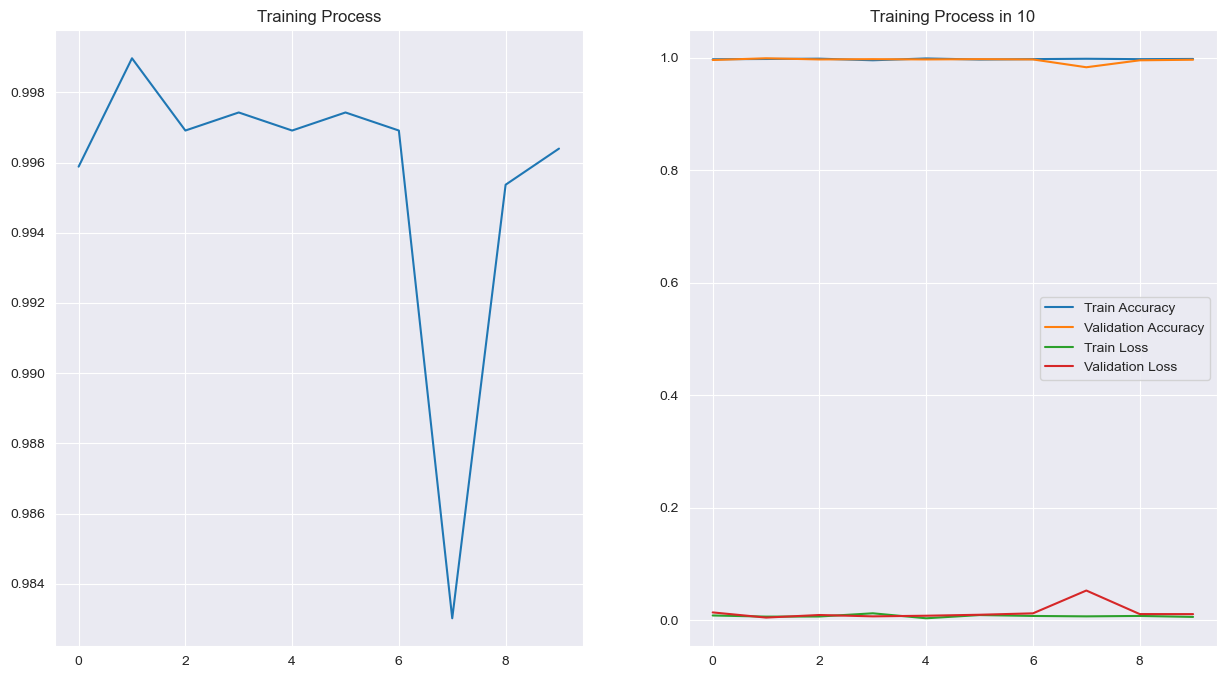

In [14]:
# Số lượng folds
n_splits = 10

# KFold
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


times=0

# Tạo và đào tạo mô hình với K-Fold
# Tạo và đào tạo mô hình với K-Fold
for train_index, val_index in kf.split(x_train,y_train):
    times+=1
    X_train_fold, X_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    # Chuyển đổi tf.Tensor thành mảng NumPy nếu cần thiết
    X_train_fold = X_train_fold.numpy() if isinstance(X_train_fold, tf.Tensor) else X_train_fold
    y_train_fold = y_train_fold.numpy() if isinstance(y_train_fold, tf.Tensor) else y_train_fold
    X_val_fold = X_val_fold.numpy() if isinstance(X_val_fold, tf.Tensor) else X_val_fold
    y_val_fold = y_val_fold.numpy() if isinstance(y_val_fold, tf.Tensor) else y_val_fold
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=64, validation_data=(X_val_fold, y_val_fold),callbacks=[wandb.keras.WandbCallback()])
    show_pic(times)


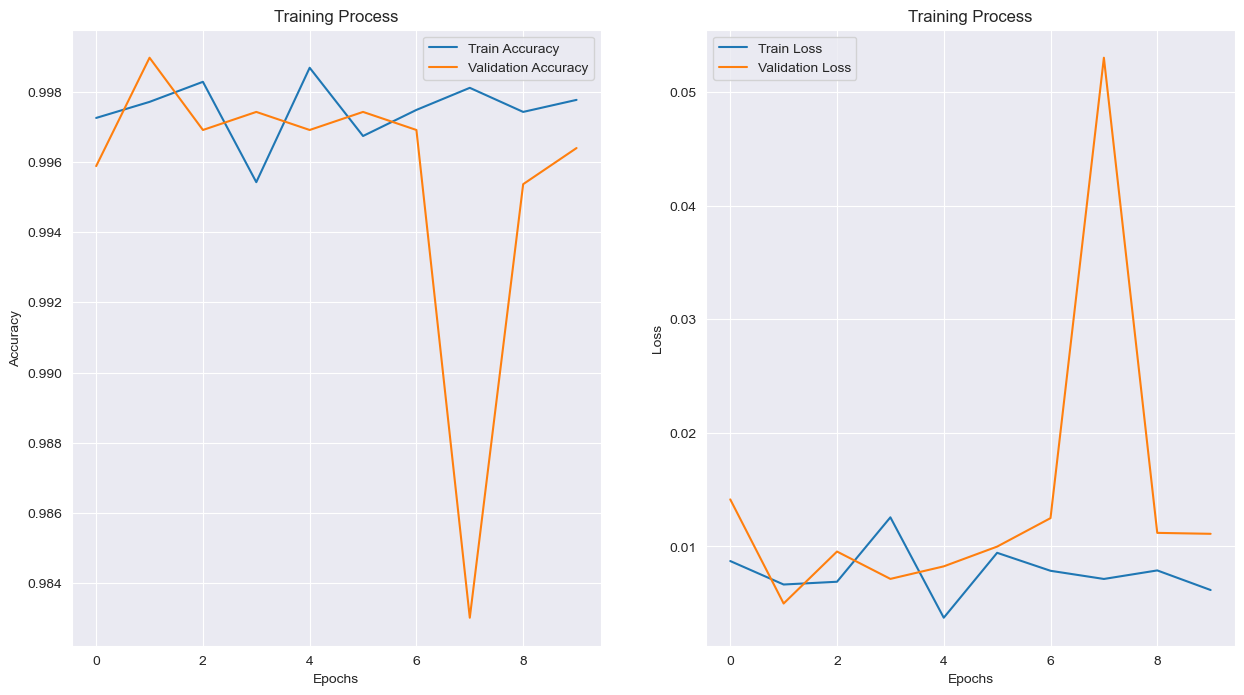

<Figure size 640x480 with 0 Axes>

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Lấy dữ liệu từ history
history = model.history.history

# Vẽ biểu đồ
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Biểu đồ accuracy của tập kiểm tra và tập validation
axes[0].plot(pd.DataFrame(history['accuracy']), label='Train Accuracy')
axes[0].plot(pd.DataFrame(history['val_accuracy']), label='Validation Accuracy')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Biểu đồ loss của tập kiểm tra và tập validation
axes[1].plot(pd.DataFrame(history['loss']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_loss']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Hiển thị biểu đồ
plt.show()

# Lưu biểu đồ vào file
plt.savefig('train.png')


In [16]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_test, predictions)
accuracy

160/160 [==============================] - 2s 14ms/step


0.9396738062487718

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Đánh giá độ chính xác
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Hiển thị báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, predictions,labels=[1,0]))

# # Hiển thị ma trận nhầm lẫn
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred,labels=[1,0]))

Accuracy: 0.9396738062487718
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       307
           0       0.94      1.00      0.97      4782

    accuracy                           0.94      5089
   macro avg       0.47      0.50      0.48      5089
weighted avg       0.88      0.94      0.91      5089



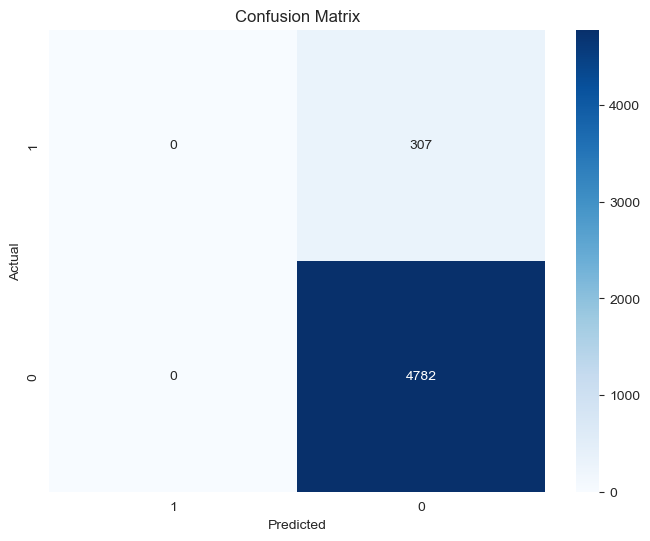

In [ ]:
# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, predictions,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

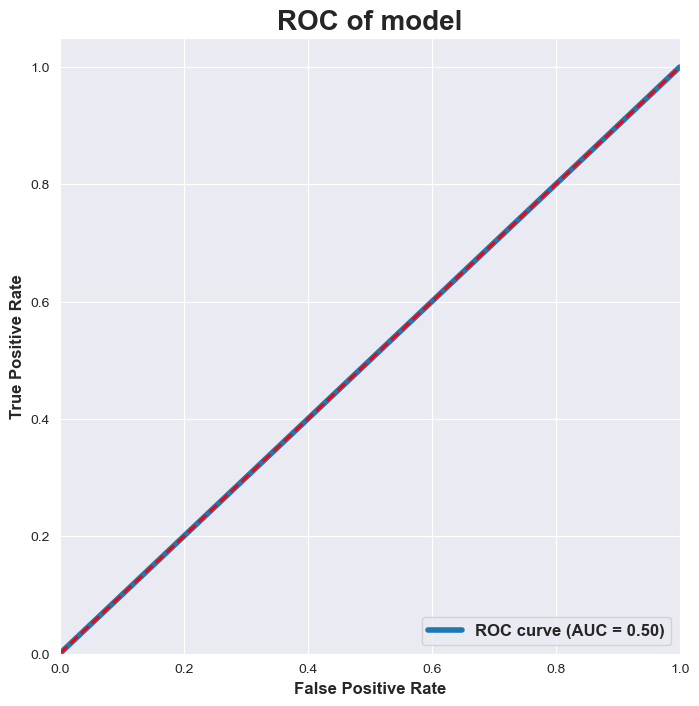

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, predictions,ax,name='model'):    
    # Tính toán FPR và TPR từ decision function
    fpr, tpr, _ = roc_curve(y_test, predictions)
    
    # Tính diện tích dưới đường cong ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Vẽ đường cong ROC
    ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  # Đặt kích thước và độ dày cho nhãn trục x
    ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   # Đặt kích thước và độ dày cho nhãn trục y
    ax.set_title(f'ROC of {name}',fontsize=20, weight='bold')  # Đặt kích thước và độ dày cho tiêu đề
    ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})  # Đặt kích thước và độ dày cho chú thích

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

plot_roc_curve(y_test,predictions,axes)
# predictions

In [19]:
def check_result(prediction):
    prediction = (prediction > 0.5).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [20]:
solandung=0
hopdonggianlan=0
for indx in range(len(x_test)):
    y_predict = predictions
    #print(y_predict[0][0])
    Y_check = check_result(y_test.iloc[indx])
    print('True:', Y_check)
    print('Predicted:', check_result(y_predict[indx]))
    print("----------------------------")
    if Y_check==check_result(y_predict[indx]):
        solandung+=1
        if Y_check=='Y':
            hopdonggianlan+=1
    

True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------


In [21]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['FraudFound_P']==1]))*100}% so với thực tế")

Số lần dự đoán đúng: 4782 chiếm khoảng 93.96738062487718% tổng lần dự đoán
Số hợp đồng gian lận trong lần kiểm tra: 0 chiếm khoảng 0.0% so với thực tế
